In [1]:
import pandas as pd
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib
import os

c:\vsc\research\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.9


In [ ]:
file_path = 'datasets/DB for chromophore_Sci_Data_rev02.csv'

df = pd.read_csv(file_path)

df = df[df["Quantum yield"].notna() & df["Chromophore"].notna() & df["Solvent"].notna()]
df = df[["Chromophore", "Solvent", "Quantum yield"]]
df = df[df["Quantum yield"] >= 0.01]  # take quantum yields bigger than 0.01
print("Filtered dataset size:", len(df))
# Optional extra dataset with SMILES / solvent / PLQY
extra_path = 'datasets/dataset2.xlsx'
if os.path.exists(extra_path):
    df_extra_raw = pd.read_excel(extra_path)
    cols_lower = {c.lower().strip(): c for c in df_extra_raw.columns}

    def pick(col_candidates):
        for name in col_candidates:
            if name.lower() in cols_lower:
                return cols_lower[name.lower()]
        return None

    chrom_col = pick(["chromophore", "smiles"])
    solv_col  = pick(["solvent"])
    qy_col    = pick(["quantum yield", "plqy", "plq y", "qy"])

    if chrom_col and solv_col and qy_col:
        df_extra = df_extra_raw[[chrom_col, solv_col, qy_col]].rename(
            columns={chrom_col: "Chromophore", solv_col: "Solvent", qy_col: "Quantum yield"}
        )
        df_extra = df_extra[df_extra["Quantum yield"].notna()
                            & df_extra["Chromophore"].notna()
                            & df_extra["Solvent"].notna()]
        df_extra = df_extra[df_extra["Quantum yield"] >= 0.01]
        print("Extra dataset usable rows:", len(df_extra))

        # Concatenate base and extra datasets
        df = pd.concat([df, df_extra], ignore_index=True)
    else:
        print("dataset2.xlsx found but required columns (SMILES/chromophore, solvent, PLQY/Quantum yield) not detected; using only base CSV.")
else:
    print("Extra dataset 'dataset2.xlsx' not found; using only base CSV.")

print("Total combined filtered dataset size:", len(df))
df.head()

Filtered dataset size: 12541
Extra dataset usable rows: 2912
Total combined filtered dataset size: 15453


,Chromophore,Solvent,Quantum yield
0,O=C([O-])c1ccccc1-c1c2ccc(=O)cc-2oc2cc([O-])ccc12,O,0.950
1,O=C([O-])c1ccccc1C1=c2cc3c4c(c2Oc2c1cc1c5c2CCC...,CO,1.000
2,O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...,O,0.200
3,O=C([O-])c1ccccc1-c1c2cc(I)c(=O)c(I)c-2oc2c(I)...,O,0.020
4,O=C([O-])c1c(Cl)c(Cl)c(Cl)c(Cl)c1-c1c2cc(I)c(=...,O,0.018


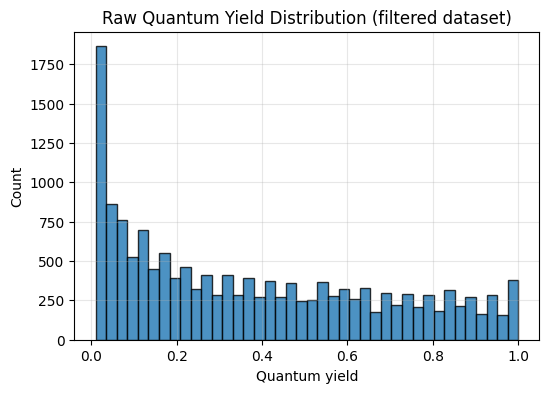

In [4]:
# Histogram of raw quantum yield distribution
plt.figure(figsize=(6,4))
plt.hist(df["Quantum yield"], bins=40, alpha=0.8, edgecolor="black")
plt.xlabel("Quantum yield")
plt.ylabel("Count")
plt.title("Raw Quantum Yield Distribution (filtered dataset)")
plt.grid(True, alpha=0.3)
plt.show()


In [5]:
model = AutoModel.from_pretrained("ibm/MoLFormer-XL-both-10pct", deterministic_eval=True, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)


In [6]:
import torch

CACHE_FILE = "embedding caches/embedding_cache.pt"

def load_cache():
    if os.path.exists(CACHE_FILE):
        return torch.load(CACHE_FILE)
    else:
        return {}  # empty cache

def save_cache(cache):
    torch.save(cache, CACHE_FILE)

In [7]:
def get_embeddings(smiles_list, batch_size=32, max_length=202):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    cache = load_cache()
    all_embeddings = []


    to_compute = [s for s in smiles_list if s not in cache]

    if len(to_compute) > 0:
        print(f"Computing {len(to_compute)} new embeddings on {device}...")


        model.to(device)
        model.eval()

        with torch.no_grad():
            for i in range(0, len(to_compute), batch_size):
                batch = to_compute[i:i+batch_size]

                inputs = tokenizer(
                    batch, padding=True, truncation=True,
                    max_length=max_length, return_tensors="pt"
                ).to(device)


                outputs = model(**inputs)
                embeddings = outputs.pooler_output 


                for s, emb in zip(batch, embeddings):
                    cache[s] = emb.cpu()


        save_cache(cache)

    else:
        print("All embeddings already in cache.")


    ordered = [cache[s] for s in smiles_list]
    return torch.stack(ordered)


In [8]:
chrom_emb = get_embeddings(df["Chromophore"].tolist())
print("Chromophore embeddings shape:", chrom_emb.shape)

solv_emb = get_embeddings(df["Solvent"].tolist())
print("Solvent embeddings shape:", solv_emb.shape)

combined_emb = torch.cat([chrom_emb, solv_emb], dim=1)
print("Combined embedding shape:", combined_emb.shape)

All embeddings already in cache.
Chromophore embeddings shape: torch.Size([15453, 768])
All embeddings already in cache.
Solvent embeddings shape: torch.Size([15453, 768])
Combined embedding shape: torch.Size([15453, 1536])


In [9]:
from sklearn.preprocessing import StandardScaler

chrom_emb_scaled = torch.tensor(StandardScaler().fit_transform(chrom_emb.numpy()), dtype=torch.float32)
solv_emb_scaled = torch.tensor(StandardScaler().fit_transform(solv_emb.numpy()), dtype=torch.float32)
combined_emb = torch.cat([chrom_emb_scaled, solv_emb_scaled], dim=1)
y = torch.tensor(df["Quantum yield"].values, dtype=torch.float32).unsqueeze(1)

In [10]:
# Instead of combining before train/test split:


# Reproducible splits
RANDOM_STATE = 42

# current variables from your notebook:
# chrom_emb_scaled (torch.Tensor, [N, D])
# solv_emb_scaled  (torch.Tensor, [N, D])
# y                (torch.Tensor, [N, 1])

# 1) Split out test set (20% of full data)
chrom_trainval, chrom_test, solv_trainval, solv_test, y_trainval, y_test = train_test_split(
    chrom_emb_scaled, solv_emb_scaled, y, test_size=0.20, random_state=RANDOM_STATE
)

# 2) Split train/validation from remaining (we want val = 10% of total)
#    trainval size = 0.80 of total; to get val=0.10 total -> val fraction of trainval = 0.10/0.80 = 0.125
val_frac_of_trainval = 0.10 / 0.80  # = 0.125
chrom_train, chrom_val, solv_train, solv_val, y_train, y_val = train_test_split(
    chrom_trainval, solv_trainval, y_trainval, test_size=val_frac_of_trainval, random_state=RANDOM_STATE
)

# Check sizes
N_total = chrom_emb_scaled.shape[0]
print(f"Total samples: {N_total}")
print(f"Train samples: {len(chrom_train)} ({len(chrom_train)/N_total:.2%})")
print(f"Val   samples: {len(chrom_val)} ({len(chrom_val)/N_total:.2%})")
print(f"Test  samples: {len(chrom_test)} ({len(chrom_test)/N_total:.2%})")

# Convert to TensorDataset (they are already torch tensors)
train_ds = TensorDataset(chrom_train, solv_train, y_train)
val_ds   = TensorDataset(chrom_val,   solv_val,   y_val)
test_ds  = TensorDataset(chrom_test,  solv_test,  y_test)

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

Total samples: 15453
Train samples: 10816 (69.99%)
Val   samples: 1546 (10.00%)
Test  samples: 3091 (20.00%)


In [11]:
# quick batch shapes
for name, loader in (("train", train_loader), ("val", val_loader), ("test", test_loader)):
    xb_ch, xb_sv, yb = next(iter(loader))
    print(f"{name} batch shapes -> chrom: {xb_ch.shape}, solv: {xb_sv.shape}, y: {yb.shape}")

train batch shapes -> chrom: torch.Size([32, 768]), solv: torch.Size([32, 768]), y: torch.Size([32, 1])
val batch shapes -> chrom: torch.Size([32, 768]), solv: torch.Size([32, 768]), y: torch.Size([32, 1])
test batch shapes -> chrom: torch.Size([32, 768]), solv: torch.Size([32, 768]), y: torch.Size([32, 1])


In [12]:
class CrossAttentionRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_heads=8, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        
        # Cross-attention layers
        self.cross_attn_layers = nn.ModuleList([
            nn.MultiheadAttention(hidden_dim, num_heads, batch_first=True)
            for _ in range(num_layers)
        ])
        
        # Layer norms
        self.norms = nn.ModuleList([
            nn.LayerNorm(hidden_dim) for _ in range(num_layers * 2)
        ])
        
        # Feed-forward networks
        self.ffns = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim * 4),
                nn.ReLU(),
                nn.Linear(hidden_dim * 4, hidden_dim)
            )
            for _ in range(num_layers)
        ])
        
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, chrom, solv):
        # Embed chromophore and solvent
        chrom = self.embedding(chrom).unsqueeze(1)  # [batch, 1, hidden_dim]
        solv = self.embedding(solv).unsqueeze(1)    # [batch, 1, hidden_dim]
        
        # Cross-attention layers
        for i, (attn, norm1, norm2, ffn) in enumerate(zip(
            self.cross_attn_layers, 
            self.norms[::2], 
            self.norms[1::2], 
            self.ffns
        )):
            # Chromophore attends to solvent
            attn_out, _ = attn(chrom, solv, solv)
            chrom = norm1(chrom + attn_out)
            ffn_out = ffn(chrom)
            chrom = norm2(chrom + ffn_out)
            
            # Solvent attends to chromophore
            attn_out, _ = attn(solv, chrom, chrom)
            solv = norm1(solv + attn_out)
            ffn_out = ffn(solv)
            solv = norm2(solv + ffn_out)
        
        # Concatenate and regress
        x = torch.cat([chrom, solv], dim=-1).flatten(1)
        return self.regressor(x)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_dim = chrom_emb_scaled.shape[1]
transformer_model = CrossAttentionRegressor(input_dim=input_dim, hidden_dim=256, num_heads=8, num_layers=2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=1e-4)

epochs = 100
train_losses = []
val_losses = []

# Early stopping parameters
early_stopping_patience = 50
best_val_loss = float('inf')
patience_counter = 0
best_epoch = 0

# Create models directory if it doesn't exist
os.makedirs("models", exist_ok=True)
best_model_path = "models/crossattention_best.pth"

print(f"Starting training with early stopping (patience={early_stopping_patience} epochs)...")
print("=" * 70)

for epoch in range(epochs):
    # Training phase
    transformer_model.train()
    total_loss = 0
    
    for chrom_batch, solv_batch, yb in train_loader:
        chrom_batch, solv_batch, yb = chrom_batch.to(device), solv_batch.to(device), yb.to(device)
        
        # Forward pass - cross-attention learns interactions
        pred = transformer_model(chrom_batch, solv_batch)
        loss = criterion(pred, yb)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    transformer_model.eval()
    val_total_loss = 0
    with torch.no_grad():
        for chrom_batch, solv_batch, yb in val_loader:
            chrom_batch, solv_batch, yb = chrom_batch.to(device), solv_batch.to(device), yb.to(device)
            pred = transformer_model(chrom_batch, solv_batch)
            loss = criterion(pred, yb)
            val_total_loss += loss.item()
    
    avg_val_loss = val_total_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch + 1
        patience_counter = 0
        # Save best model
        torch.save(transformer_model.state_dict(), best_model_path)
    else:
        patience_counter += 1
    
    # Print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | "
              f"Best Val Loss: {best_val_loss:.6f} (Epoch {best_epoch}) | Patience: {patience_counter}/{early_stopping_patience}")
    
    # Check for early stopping
    if patience_counter >= early_stopping_patience:
        print(f"\n{'='*70}")
        print(f"Early stopping triggered! No improvement for {early_stopping_patience} epochs.")
        print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_epoch}")
        print(f"Stopping training at epoch {epoch + 1}")
        print(f"{'='*70}")
        break

# Load best model
transformer_model.load_state_dict(torch.load(best_model_path))
print(f"\nTraining complete! Best model saved at: {best_model_path}")
print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_epoch}")
print(f"Total epochs trained: {len(train_losses)}")

Using device: cuda
Starting training with early stopping (patience=50 epochs)...
Epoch 1/100 | Train Loss: 0.079042 | Val Loss: 0.065412 | Best Val Loss: 0.065412 (Epoch 1) | Patience: 0/50
Epoch 10/100 | Train Loss: 0.026768 | Val Loss: 0.042441 | Best Val Loss: 0.042441 (Epoch 10) | Patience: 0/50
Epoch 20/100 | Train Loss: 0.014065 | Val Loss: 0.036572 | Best Val Loss: 0.036572 (Epoch 20) | Patience: 0/50
Epoch 30/100 | Train Loss: 0.008914 | Val Loss: 0.035905 | Best Val Loss: 0.035905 (Epoch 30) | Patience: 0/50
Epoch 40/100 | Train Loss: 0.006603 | Val Loss: 0.035283 | Best Val Loss: 0.035283 (Epoch 40) | Patience: 0/50
Epoch 50/100 | Train Loss: 0.005676 | Val Loss: 0.035715 | Best Val Loss: 0.034510 (Epoch 46) | Patience: 4/50
Epoch 60/100 | Train Loss: 0.004537 | Val Loss: 0.034451 | Best Val Loss: 0.033947 (Epoch 57) | Patience: 3/50
Epoch 70/100 | Train Loss: 0.003435 | Val Loss: 0.033639 | Best Val Loss: 0.033639 (Epoch 70) | Patience: 0/50
Epoch 80/100 | Train Loss: 0.0033


=== Cross-Attention Model Test Set Evaluation ===
R² Score: 0.5985
MAE: 0.1342
RMSE: 0.1911


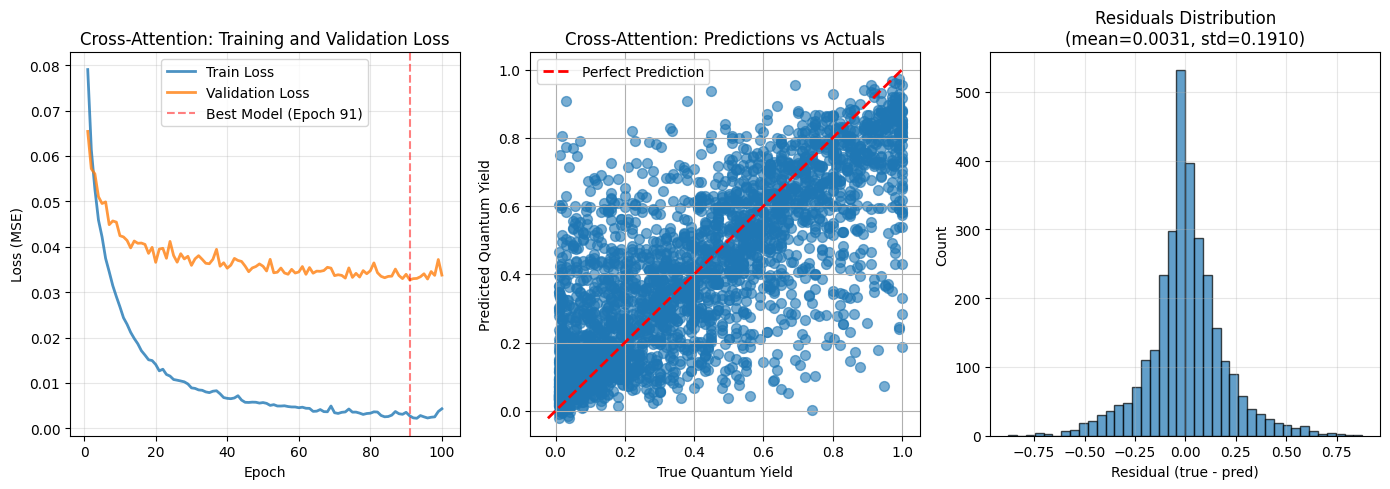


Residuals - Mean: 0.0031, Std: 0.1910


In [14]:
# Plot training and validation loss curves
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
epochs_list = range(1, len(train_losses) + 1)
plt.plot(epochs_list, train_losses, label='Train Loss', alpha=0.8, linewidth=2)
if 'val_losses' in locals() and len(val_losses) > 0:
    plt.plot(epochs_list, val_losses, label='Validation Loss', alpha=0.8, linewidth=2)
if 'best_epoch' in locals():
    plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label=f'Best Model (Epoch {best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Cross-Attention: Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Test set evaluation
transformer_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for chrom_batch, solv_batch, yb in test_loader:
        chrom_batch, solv_batch, yb = chrom_batch.to(device), solv_batch.to(device), yb.to(device)
        
        # Forward pass with separate chromophore and solvent
        pred = transformer_model(chrom_batch, solv_batch)
        y_true.append(yb.cpu())
        y_pred.append(pred.cpu())

y_true = torch.cat(y_true).squeeze().numpy()
y_pred = torch.cat(y_pred).squeeze().numpy()

r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("\n=== Cross-Attention Model Test Set Evaluation ===")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

plt.subplot(1, 3, 2)
plt.scatter(y_true, y_pred, alpha=0.6, s=50)
mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel("True Quantum Yield")
plt.ylabel("Predicted Quantum Yield")
plt.title("Cross-Attention: Predictions vs Actuals")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
residuals = y_true - y_pred
plt.hist(residuals, bins=40, alpha=0.7, edgecolor='black')
plt.xlabel("Residual (true - pred)")
plt.ylabel("Count")
plt.title(f"Residuals Distribution\n(mean={residuals.mean():.4f}, std={residuals.std():.4f})")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional metrics
print(f"\nResiduals - Mean: {residuals.mean():.4f}, Std: {residuals.std():.4f}")

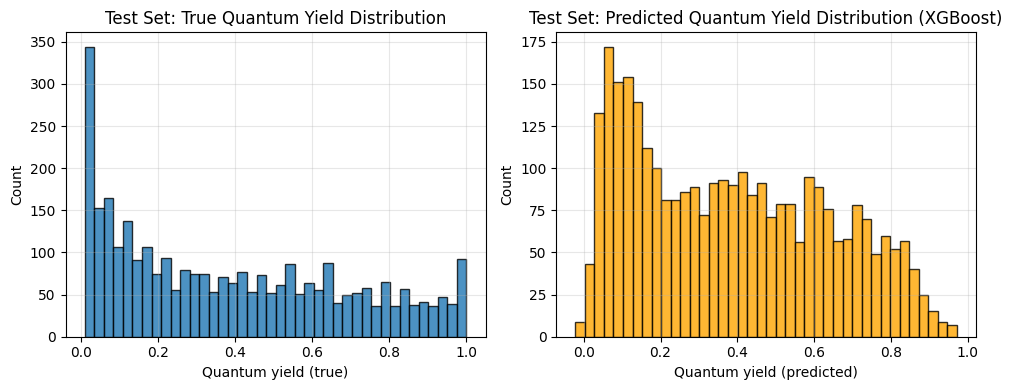

In [15]:
# Histograms of quantum yield after modeling (test set)
plt.figure(figsize=(10,4))

# True distribution on test set
plt.subplot(1,2,1)
plt.hist(y_true, bins=40, alpha=0.8, edgecolor="black")
plt.xlabel("Quantum yield (true)")
plt.ylabel("Count")
plt.title("Test Set: True Quantum Yield Distribution")
plt.grid(True, alpha=0.3)

# Predicted distribution on test set (XGBoost)
plt.subplot(1,2,2)
plt.hist(y_pred, bins=40, alpha=0.8, edgecolor="black", color="orange")
plt.xlabel("Quantum yield (predicted)")
plt.ylabel("Count")
plt.title("Test Set: Predicted Quantum Yield Distribution (XGBoost)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



=== Transformer/CrossAttention Validation Results ===
Samples: 1546
R²   : 0.6389
MAE  : 0.1267
RMSE : 0.1804


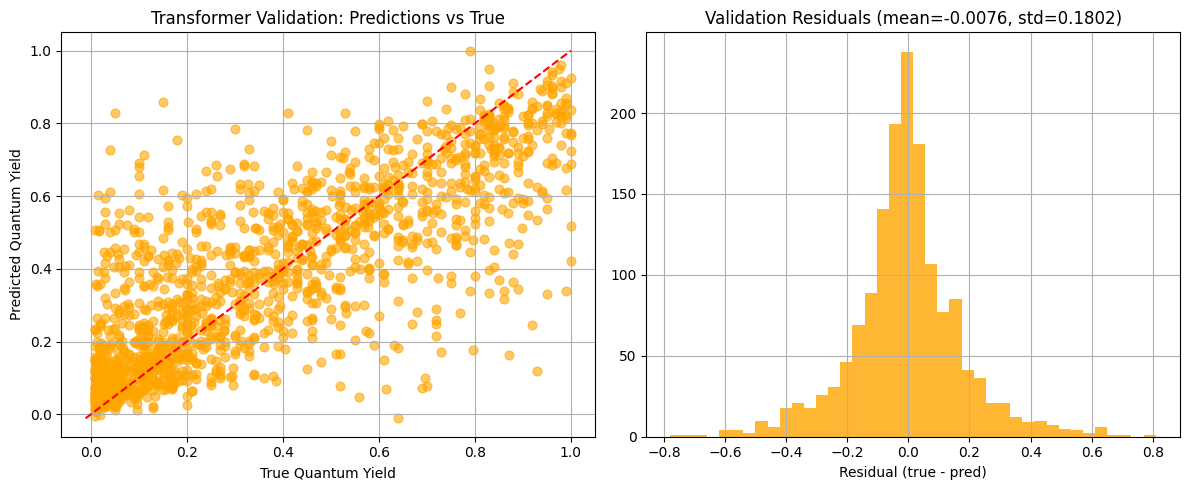

In [ ]:
# Validation Set Evaluation for Transformer/CrossAttention
print("\n" + "="*50)
print("=== Transformer/CrossAttention Validation Results ===")
print("="*50)

transformer_model.eval()
y_val_true_list, y_val_pred_list = [], []

with torch.no_grad():
    for chrom_batch, solv_batch, yb in val_loader:
        chrom_batch = chrom_batch.to(device)
        solv_batch  = solv_batch.to(device)
        yb = yb.to(device)

        pred = transformer_model(chrom_batch, solv_batch)
        y_val_true_list.append(yb.cpu())
        y_val_pred_list.append(pred.cpu())

y_val_true = torch.cat(y_val_true_list).squeeze().numpy()
y_val_pred = torch.cat(y_val_pred_list).squeeze().numpy()

r2_val  = r2_score(y_val_true, y_val_pred)
mae_val = mean_absolute_error(y_val_true, y_val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val_true, y_val_pred))

print(f"Samples: {len(y_val_true)}")
print(f"R²   : {r2_val:.4f}")
print(f"MAE  : {mae_val:.4f}")
print(f"RMSE : {rmse_val:.4f}")

# Plots: validation parity and residuals
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_val_true, y_val_pred, alpha=0.6, s=40, color='orange')
mn, mx = min(y_val_true.min(), y_val_pred.min()), max(y_val_true.max(), y_val_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', lw=1.5)
plt.xlabel("True Quantum Yield")
plt.ylabel("Predicted Quantum Yield")
plt.title("Transformer Validation: Predictions vs True")
plt.grid(True)

plt.subplot(1, 2, 2)
residuals_val = y_val_true - y_val_pred
plt.hist(residuals_val, bins=40, alpha=0.8, color='orange')
plt.xlabel("Residual (true - pred)")
plt.title(f"Validation Residuals (mean={residuals_val.mean():.4f}, std={residuals_val.std():.4f})")
plt.grid(True)

plt.tight_layout()
plt.show()


In [17]:
# Train Set Evaluation and Comparison DataFrame
print("\n" + "="*50)
print("=== Train Set Evaluation ===")
print("="*50)

transformer_model.eval()
y_train_true_list, y_train_pred_list = [], []

with torch.no_grad():
    for chrom_batch, solv_batch, yb in train_loader:
        chrom_batch = chrom_batch.to(device)
        solv_batch  = solv_batch.to(device)
        yb = yb.to(device)

        pred = transformer_model(chrom_batch, solv_batch)
        y_train_true_list.append(yb.cpu())
        y_train_pred_list.append(pred.cpu())

y_train_true = torch.cat(y_train_true_list).squeeze().numpy()
y_train_pred = torch.cat(y_train_pred_list).squeeze().numpy()

r2_train  = r2_score(y_train_true, y_train_pred)
mae_train = mean_absolute_error(y_train_true, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train_true, y_train_pred))

print(f"Samples: {len(y_train_true)}")
print(f"R²   : {r2_train:.4f}")
print(f"MAE  : {mae_train:.4f}")
print(f"RMSE : {rmse_train:.4f}")

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    "Set": ["Train", "Validation", "Test"],
    "Samples": [len(y_train_true), len(y_val_true), len(y_true)],
    "R²": [r2_train, r2_val, r2],
    "MAE": [mae_train, mae_val, mae],
    "RMSE": [rmse_train, rmse_val, rmse]
})

print("\n" + "="*50)
print("=== Model Performance Comparison ===")
print("="*50)
print(comparison_df.to_string(index=False))



=== Train Set Evaluation ===
Samples: 10816
R²   : 0.9768
MAE  : 0.0342
RMSE : 0.0462

=== Model Performance Comparison ===
       Set  Samples       R²      MAE     RMSE
     Train    10816 0.976765 0.034170 0.046192
Validation     1546 0.638882 0.126733 0.180400
      Test     3091 0.598542 0.134161 0.191054
